In [2]:
from utils import *

In [3]:
def flood_fill(test_array,h_max=255):
    input_array = np.copy(test_array) 
    el = sp.ndimage.generate_binary_structure(2,2).astype(int)
    inside_mask = sp.ndimage.binary_erosion(~np.isnan(input_array), structure=el)
    output_array = np.copy(input_array)
    output_array[inside_mask]=h_max
    output_old_array = np.copy(input_array)
    output_old_array.fill(0)   
    el = sp.ndimage.generate_binary_structure(2,1).astype(int)
    while not np.array_equal(output_old_array, output_array):
        output_old_array = np.copy(output_array)
        output_array = np.maximum(input_array,sp.ndimage.grey_erosion(output_array, size=(3,3), footprint=el))
    return output_array

In [4]:
def bwareaopen(img, min_size, connectivity=8):
        """Remove small objects from binary image (approximation of 
        bwareaopen in Matlab for 2D images).
    
        Args:
            img: a binary image (dtype=uint8) to remove small objects from
            min_size: minimum size (in pixels) for an object to remain in the image
            connectivity: Pixel connectivity; either 4 (connected via edges) or 8 (connected via edges and corners).
    
        Returns:
            the binary image with small objects removed
        """
    
        # Find all connected components (called here "labels")
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            img, connectivity=connectivity)
        
        # check size of all connected components (area in pixels)
        for i in range(num_labels):
            label_size = stats[i, cv2.CC_STAT_AREA]
            
            # remove connected components smaller than min_size
            if label_size < min_size:
                img[labels == i] = 0
                
        return img

In [5]:
def get_faces(img):
    
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    #inverse of the avg values of the RBG
    mR = 1/(np.mean(np.mean(R)))
    mG = 1/(np.mean(np.mean(G)))
    mB = 1/(np.mean(np.mean(B)))
    # smallest avg value
    maxRGB = max(max(mR, mG), mB)
    
    #calculate the scaling factors
    mR = mR/maxRGB
    mG = mG/maxRGB
    mB = mB/maxRGB

    out = np.zeros(img.shape)
    out = np.array(out, dtype=np.uint8)
    #scale the values
    out[:,:,0]=R*mR
    out[:,:,1]=G*mG
    out[:,:,2]=B*mB

    #convert the RGB image to YCbCr
    img_ycbcr =  cv2.cvtColor(out, cv2.COLOR_BGR2YCR_CB)

    #3. Extracting each component
    Y= img_ycbcr[:,:,0]
    Cb= img_ycbcr[:,:,1]
    Cr= img_ycbcr[:,:,2]

    #4. perform multi-level tresholding
    r = []
    c = []
    for i in range(img_ycbcr.shape[0]):
        for j in range(img_ycbcr.shape[1]):
            if Cb[i,j]>=77 and Cb[i,j]<=127 and Cr[i,j]>=133 and Cr[i,j]<=193 :
                r.append(i)
                c.append(j)

    numind=len(r)
    bin=np.zeros((img.shape[0],img.shape[1]))
    bin = np.array(bin, dtype=np.uint8)

    for i in range(numind):
        bin[r[i],c[i]]=1
    bin = flood_fill(bin)
    bin=bwareaopen(bin,9000)
    R[bin == 0]=0
    G[bin == 0]=0
    B[bin == 0]=0

    out[:,:,0] = R
    out[:,:,1] = G
    out[:,:,2] = B

    out_gray = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
    out_gray[out_gray > 0] = 1
    bounding_boxes = find_contours(out_gray, 0.8)

    comps,labels= cv2.connectedComponents(out_gray, connectivity=8)

    arr = []
    for k in range(1,comps+1):
        xcoordinate, ycoordinate = np.where(labels==k)
        #print(ycoordinate)
        #print(xcoordinate)
        max_x = -9999999999
        min_x = 9999999999

        max_y = -999999999
        min_y = 99999999999
        for j in range(xcoordinate.shape[0]):
            ypoint = ycoordinate[j]
            xpoint = xcoordinate[j]
            if(xpoint > max_x):
                max_x = xpoint
            if(xpoint < min_x):
                min_x = xpoint
            if(ypoint > max_y):
                max_y = ypoint
            if(ypoint < min_y):
                min_y = ypoint
        
        arr.append([min_y, min_x, max_y-min_y, max_x-min_x])
    return arr


In [76]:
def is_face_candidate(face):
    (x, y, w, h) = face
    if(w < 50 or h < 50):
        return False
    if(w / h > 2.0):
        return False
    if(h / w > 2.0):
        return False
    return True

In [7]:
def map_emotion(label):
    if(label == 1):
        return "happy"
    if(label == 2):
        return "sad"
    if(label == 3):
        return "angry"
    if(label == 4):
        return "disgusted"
    if(label == 5):
        return "fearful"
    if(label == 6):
        return "neutral"
    if(label == 7):
        return "surprised"

### Apply the algorithm on a VIDEO (frame per second)

In [28]:
def get_emotions_from_video(vid_path):
    model = pickle.load(open("model2.sav", 'rb'))
    pca = pickle.load(open('model_2_PCA.sav', 'rb'))
    imgs = []
    cap = cv2.VideoCapture(vid_path)
    frameRate = cap.get(5)  # frame rate
    x = 1
    count = 0
    frames = []
    while(cap.isOpened()):
        frameId = cap.get(1)  # current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        
        frame_cpy = frame.copy()
        if (frameId % np.floor(frameRate) == 0 and frameId != 0):
            count = count+1
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            print("Got a Frame")
            faces = get_faces(frame_rgb)
            print("Got_faces")
            # remove Noise
            faces = filter(is_face_candidate, faces)
            faces = list(faces)
            print(faces)
            # For each face detected
            for (x, y, w, h) in faces:
                # extract region of interest

                roi = frame_cpy[y:y+h, x: x+w]
                # convert to gray
                roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                # resize to 60 x 60
                roi = cv2.resize(roi, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
                # apply LPQ
                lpq = apply_LPQ(roi, 5) 
                lpq, _ = np.histogram(lpq, 256)
                # apply PHOG
                phog = PHOG_Algorithm(roi, 8, 3)
                features = phog
                features = features.reshape((1, -1))
                feats = pca.transform(features)
                emotion = model.predict(feats)
                emotion_label = map_emotion(emotion[0])
                print(emotion_label)
                frame_cpy = cv2.rectangle(frame_cpy, (x, y), (x+w, y+h), (0, 255, 0), 7)
                image = cv2.putText(image, emotion_label, (x,y),cv2.FONT_HERSHEY_COMPLEX, 2, (255,0,0), 3)
                # add emotion text on top of the rectangle
            imgs.append(frame_cpy)
    return imgs


### Apply Algorithm on a Signle Image

In [48]:
def get_emotions_from_image(img, mod = 1):
    # make a copy to edit
    if(mod == 1):
        model = pickle.load(open("model1.sav", 'rb'))
        pca = pickle.load(open('model_1_PCA.sav', 'rb'))
    else:
        model = pickle.load(open("model2.sav", 'rb'))
        pca = pickle.load(open('model_2_PCA.sav', 'rb'))
       
    image = img.copy()
    # 1- get the faces 
    faces = get_faces(img)
    faces = filter(is_face_candidate, faces)
    faces = list(faces)
    print(faces)
    
    # For each face detected
    for (x, y, w, h) in faces:
        # extract region of interest
        roi = image[y:y+h, x: x+w]
        # convert to gray
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        # resize to 60 x 60
        roi = cv2.resize(roi, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
        # apply LPQ
        lpq = apply_LPQ(roi, 5) 
        lpq, _ = np.histogram(lpq, 256)
        # apply PHOG
        phog = PHOG_Algorithm(roi, 8, 3)
        if(mod == 1):
            features = np.concatenate((lpq, phog))
        else:
            features = phog
        # features = phog
        features = features.reshape((1, -1))
        feats = pca.transform(features)
        emotion = model.predict(feats)
        # return the emotion as a String
        emotion_label = map_emotion(emotion[0])
        print(emotion_label)
        image = cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 7)
        image = cv2.putText(image, emotion_label, (x+100,y+100),cv2.FONT_HERSHEY_COMPLEX, 2, (255,0,0), 3)
    return image

#### Testing for a video

Got a Frame


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


Got_faces
[[532, 231, 467, 672]]
sad
Got a Frame


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


Got_faces
[[695, 0, 560, 433], [1248, 430, 361, 371], [1098, 836, 205, 243]]
sad
happy
neutral
Got a Frame


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


Got_faces
[[750, 0, 509, 434], [572, 245, 283, 250], [1160, 312, 331, 329], [928, 666, 387, 413]]
sad
neutral
sad
fearful
Got a Frame


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


Got_faces
[[621, 132, 318, 431], [1146, 326, 397, 489]]
happy
happy


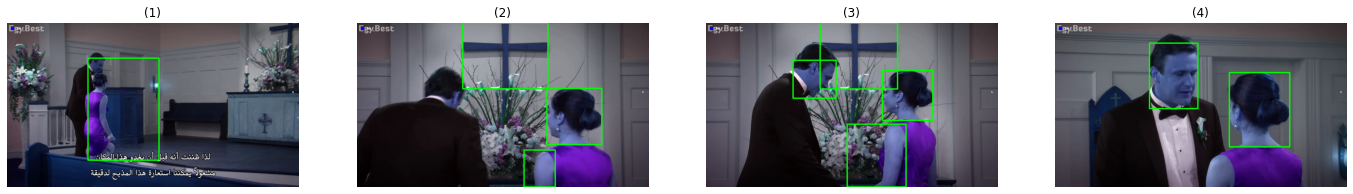

In [26]:
imgs = get_emotions_from_video('m.mp4')
show_images(imgs)

### Testing for Images

C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[172, 49, 251, 366], [187, 357, 232, 142]]
neutral
neutral


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[172, 49, 251, 366], [187, 357, 232, 142]]
happy
sad


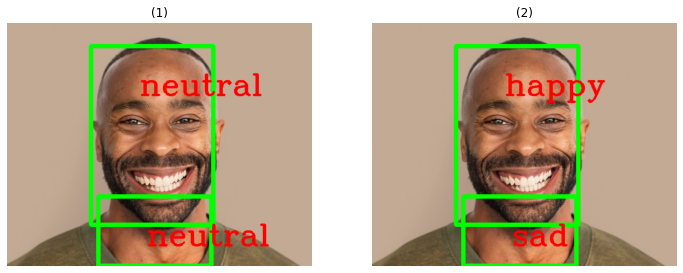

In [86]:
img = io.imread("test_cases/handsome-man-smiling-happy-face-portrait-close-up_53876-146189.jpg")
img2 = np.copy(img)
res1 = get_emotions_from_image(img, 1)
res2 = get_emotions_from_image(img2, 2)
show_images([res1, res2])

C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[418, 37, 439, 721]]
surprised


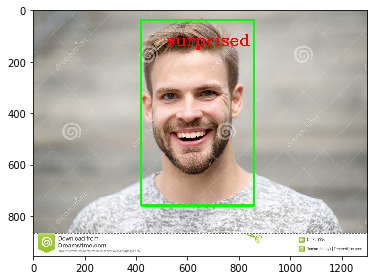

In [49]:
img = io.imread("test_cases/man-perfect-brilliant-smile-unshaven-face-defocused-background-guy-happy-emotional-expression-outdoors-bearded-man-124640934.jpg")
res = get_emotions_from_image(img, 1)
io.imshow(res);

C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[866, 113, 820, 1595]]
neutral


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[866, 113, 820, 1595]]
angry


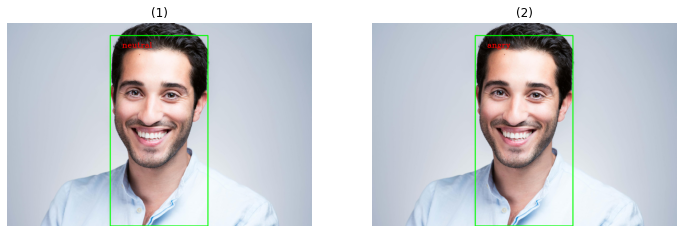

In [85]:
img = io.imread("test_cases/Headshots_Prague-emotional-portrait-of-a-smiling-entrepreneur-1.jpg")
img2 = np.copy(img)
res1 = get_emotions_from_image(img, 1)
res2 = get_emotions_from_image(img2, 2)
show_images([res1, res2])

C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[314, 51, 319, 414], [0, 382, 208, 166]]
fearful
surprised


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[314, 51, 319, 414], [0, 382, 208, 166]]
happy
sad


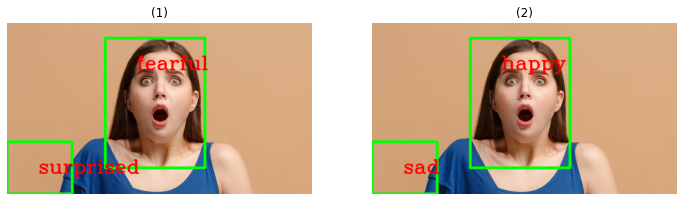

In [84]:
img = io.imread("tests/3.jpg")
img2 = np.copy(img)
res1 = get_emotions_from_image(img, 1)
res2 = get_emotions_from_image(img2, 2)
show_images([res1, res2])

C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[231, 0, 679, 719]]
sad


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[231, 0, 679, 719]]
angry


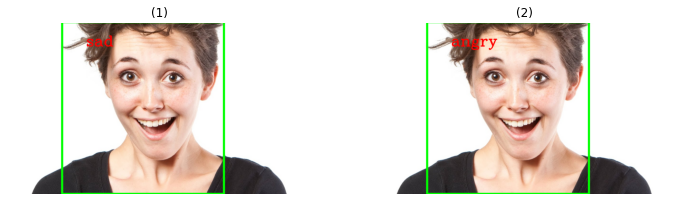

In [83]:
img = io.imread("tests/4.jpg")
img2 = np.copy(img)
res1 = get_emotions_from_image(img, 1)
res2 = get_emotions_from_image(img2, 2)
show_images([res1, res2])

C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[0, 113, 1517, 1300], [99, 1142, 393, 271], [1700, 1181, 307, 232]]
neutral
sad
sad


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[0, 113, 1517, 1300], [99, 1142, 393, 271], [1700, 1181, 307, 232]]
angry
sad
disgusted


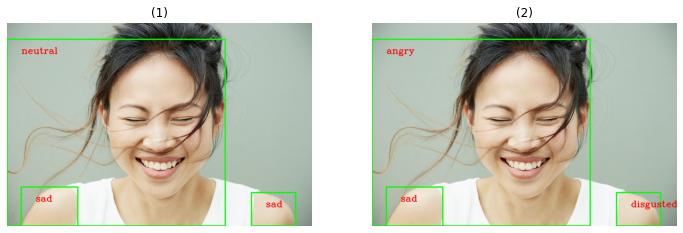

In [82]:
img = io.imread("tests/7.jpg")
img2 = np.copy(img)
res1 = get_emotions_from_image(img, 1)
res2 = get_emotions_from_image(img2, 2)
show_images([res1, res2])

C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[27, 22, 130, 171]]
fearful


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[27, 22, 130, 171]]
fearful


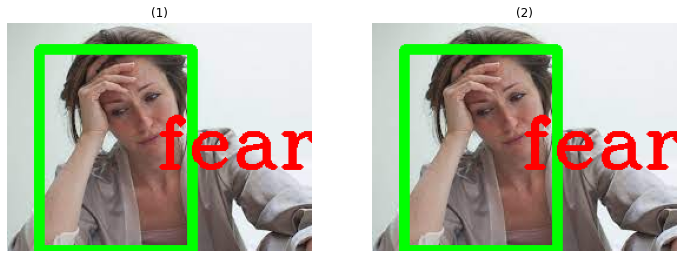

In [78]:
img = io.imread("tests/9.jpg")
img2 = np.copy(img)
res1 = get_emotions_from_image(img, 1)
res2 = get_emotions_from_image(img2, 2)
show_images([res1, res2])

C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[64, 27, 587, 594], [0, 1008, 134, 143]]
neutral
sad


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[64, 27, 587, 594], [0, 1008, 134, 143]]
happy
sad


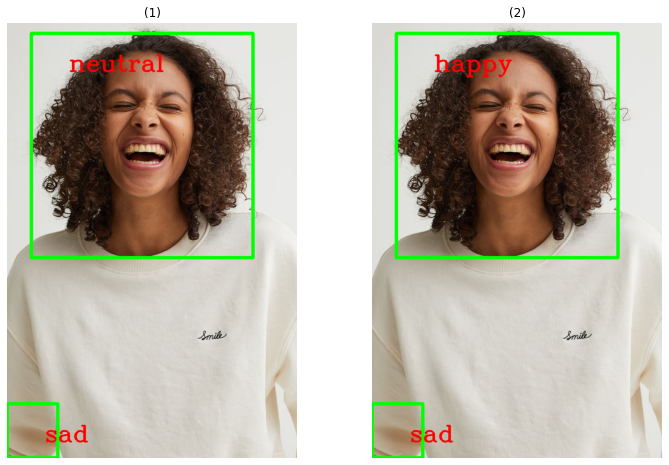

In [80]:
img = io.imread("tests/1.jpg")
img2 = np.copy(img)
res1 = get_emotions_from_image(img, 1)
res2 = get_emotions_from_image(img2, 2)
show_images([res1, res2])

C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[136, 125, 520, 677], [987, 195, 509, 692]]
neutral
neutral


C:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


[[136, 125, 520, 677], [987, 195, 509, 692]]
sad
happy


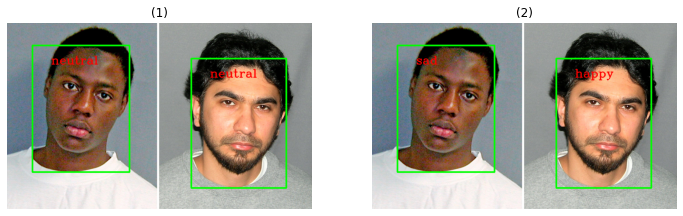

In [81]:
img = io.imread("tests/2.jpg")
img2 = np.copy(img)
res1 = get_emotions_from_image(img, 1)
res2 = get_emotions_from_image(img2, 2)
show_images([res1, res2])